# Covid Tweets Sentiment Analisys
https://www.kaggle.com/datatattle/covid-19-nlp-text-classification?select=Corona_NLP_test.csv

## Temat: Wpływ metod wektoryzacji na jakość modelu na przykładzie BOW, TF-IDF oraz biblioteki XGBoost

Wykonujący ćwiczenie:

Radosław Biedrzycki

Kasper Seweryn-Ładyński

Magdalena Sawicka

Studia dzienne

Kierunek: Informatyka

Semestr: IV                                           

Grupa zajęciowa: Grupa PS9

Prowadzący ćwiczenie: Michał Czołombitko

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import TweetTokenizer
import matplotlib
from matplotlib import pyplot
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost
xgboost.set_config(verbosity=2)
from xgboost import XGBClassifier

In [2]:
train_data_path = "../datasets/Corona_NLP_train.csv"

In [3]:
train = pd.read_csv(train_data_path)

In [4]:
train.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÜT: 36.319708,-82.363649",16-03-2020,As news of the regions first confirmed COVID-...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


<AxesSubplot:>

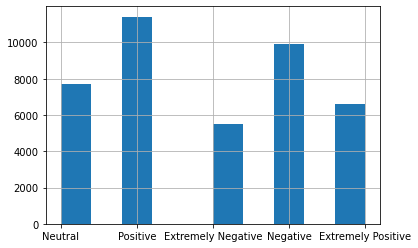

In [5]:
train["Sentiment"].hist()

## Tokenizacja

In [6]:
feats = ["OriginalTweet", "Sentiment"]
train = train[feats]

Ze zbioru treningowego wybrano interesujące nas kolumny, tj. zawierające treść tweeta i etykietę, określającą sentyment.

In [7]:
def preprocess_tweets(tweet, tokenizer=TweetTokenizer(strip_handles=True, reduce_len=True)):
    doc = nlp(" ".join(tokenizer.tokenize(tweet)))
    return " ".join([token.lemma_ for token in doc])

In [8]:
%time train["preprocessed_tweet"] = train["OriginalTweet"].map(preprocess_tweets)

Wall time: 4min


Funkcja preprocess_tweets wykorzystuje zawarty w bibliotece NLTK TweetTokenizer, aby usunąć z tweetów odwołania do innych użytkowników oraz zredukować zbędne litery w wyrazach. Następnie następuje proces lematyzacji (zamiany słowa na zawarte w słowniku słowo bazowe) przy pomocy obiektu biblioteki Spacy. Co istotne, ten pretrenowany model automatycznie rozpoznaje części mowy w zdaniach, na podstawie kontekstu, co znacząco ułatwia wstępną obróbkę danych.

In [9]:
train.head(10)

,OriginalTweet,Sentiment,preprocessed_tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,https://t.co/iFz9FAn2 Pa and https://t.co/xx6g...
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbour family to exchan...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia : woolworth to give elde...
3,My food stock is not the only one which is emp...,Positive,my food stock be not the only one which be emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"I , ready to go at supermarket during the # co..."
5,As news of the regions first confirmed COVID-...,Positive,as news of the region  s first confirm COVID ...
6,Cashier at grocery store was sharing his insig...,Positive,Cashier at grocery store be share his insight ...
7,Was at the supermarket today. Didn't buy toile...,Neutral,be at the supermarket today . do n't buy toile...
8,Due to COVID-19 our retail store and classroom...,Positive,due to COVID - 19 our retail store and classro...
9,"For corona prevention,we should stop to buy th...",Negative,"for corona prevention , we should stop to buy ..."


In [10]:
train["Sentiment"].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [11]:
def tranform_sentiment_to_label(sentiment):
    labels = {
        "Extremely Negative": -2,
        "Negative": -1,
        "Neutral": 0,
        "Positive": 1,
        "Extremely Positive": 2
    }
    return labels[sentiment]

In [12]:
%time train["target_var"] = train["Sentiment"].map(tranform_sentiment_to_label)

Wall time: 15 ms


Każdej etykiecie przypisujemy wartość liczbową na późniejszy użytek modelu.

In [13]:
train.head(10)

,OriginalTweet,Sentiment,preprocessed_tweet,target_var
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,https://t.co/iFz9FAn2 Pa and https://t.co/xx6g...,0
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbour family to exchan...,1
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia : woolworth to give elde...,1
3,My food stock is not the only one which is emp...,Positive,my food stock be not the only one which be emp...,1
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"I , ready to go at supermarket during the # co...",-2
5,As news of the regions first confirmed COVID-...,Positive,as news of the region  s first confirm COVID ...,1
6,Cashier at grocery store was sharing his insig...,Positive,Cashier at grocery store be share his insight ...,1
7,Was at the supermarket today. Didn't buy toile...,Neutral,be at the supermarket today . do n't buy toile...,0
8,Due to COVID-19 our retail store and classroom...,Positive,due to COVID - 19 our retail store and classro...,1
9,"For corona prevention,we should stop to buy th...",Negative,"for corona prevention , we should stop to buy ...",-1


In [14]:
# train.to_hdf("../datasets/train_preproccessed.h5", "df")

## Tworzenie macierzy Bag of Words

In [15]:
vectorizer = CountVectorizer(analyzer='word', max_features = 10000)
train_bow_matrix = vectorizer.fit_transform(train["preprocessed_tweet"]).todense()
train_bow_matrix

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0]], dtype=int64)

Stworzono macierz w technice Bag of Words, tj. każdemu słowu w obiekcie przypisano częstość jego występowania. Dla redukcji wymiarowości wzięto pod uwagę jedynie 10000 najczęściej występujących terminów.

In [16]:
f"The shape of Bag of Words matrix is {train_bow_matrix.shape}"

'The shape of Bag of Words matrix is (41157, 10000)'

## Tworzenie macierzy zawierającej wyłącznie wartości boolowskie na bazie BOW

In [17]:
bool_matrix = train_bow_matrix.astype('bool').astype('int8')
bool_matrix

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]], dtype=int8)

Dla porównania stworzono macierz, która uwzględnia jedynie, czy dane słowo występuje w danym obiekcie.

In [18]:
bool_matrix.shape

(41157, 10000)

## Tworzenie macierzy TF-IDF

In [19]:
vectorizer_l1_norm = TfidfVectorizer(norm="l1", max_features=10000)
tf_idf_matrix = vectorizer_l1_norm.fit_transform(train["preprocessed_tweet"]).todense()
tf_idf_matrix

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.07036195, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

TF-IDF jest techniką, która oprócz częstości występowania danego obiektu, bierze pod uwagę również jego popularność w skali całego zbioru. Jeśli słowo występuje w większości dokumentów, będzie znaczyło mniej od słowa występującego jedynie w niewielkim podzbiorze całości.

In [20]:
f"The shape of TF-IDF matrix is {tf_idf_matrix.shape}"

'The shape of TF-IDF matrix is (41157, 10000)'

## Tworzenie macierzy word2vec przy pomocy gotowych model

In [21]:
import gensim.downloader

c:\users\radosław\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [22]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [23]:
glove_vectors = gensim.downloader.load('glove-twitter-25')

In [24]:
type(glove_vectors)

gensim.models.keyedvectors.KeyedVectors

######  word2vec jest techniką, która przy pomocy reprezantacji poszczególnych słów w formie całego wektora, umożliwia uchwycenie pewnych zależności pomiędzy słowami. Przykładowo kąt między wektorami reprezentującymi wyrazy "samochód" i "ciężarówka" powinien być mniejszy, niż pomiędzy wektorami odpowiadającymi wyrazom "samochód" oraz "kangur". Niestety z braku czasu nie zdążyliśmy uwzględnić word2vec w trenowanych modelach.

## Użyty model - XGBClassifier

In [25]:
y = train['target_var'].astype('int8')
y

0        0
1        1
2        1
3        1
4       -2
        ..
41152    0
41153   -2
41154    1
41155    0
41156   -1
Name: target_var, Length: 41157, dtype: int8

In [26]:
y.shape

(41157,)

In [27]:
def train_and_draw_learning_curve(X, y=y, n_estimators=500):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = XGBClassifier(n_estimators=n_estimators, n_jobs=-1, silent=True)
    evalset = [(X_train, y_train), (X_test,y_test)]
    model.fit(X_train, y_train, eval_metric='mlogloss', eval_set=evalset)
    yhat = model.predict(X_test)
    score = accuracy_score(y_test, yhat)
    print('Accuracy: %.3f' % score)
    results = model.evals_result()
    pyplot.plot(results['validation_0']['mlogloss'], label='train')
    pyplot.plot(results['validation_1']['mlogloss'], label='test')
    pyplot.legend()
    pyplot.show()
    return score

### Trening modelu - Bag of Words

c:\users\radosław\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:01:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:02:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[21:02:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[21:02:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[21:02:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.

[21:02:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:02:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-mlogloss:1.30811	validation_1-mlogloss:1.34637
[21:02:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[21:02:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:02:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:02:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src

[21:03:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:03:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-mlogloss:1.20921	validation_1-mlogloss:1.27337
[21:03:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:03:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[21:03:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:03:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:04:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:04:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[26]	validation_0-mlogloss:1.14453	validation_1-mlogloss:1.23228
[21:04:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[21:04:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:04:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:04:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:05:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:05:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[35]	validation_0-mlogloss:1.09525	validation_1-mlogloss:1.20168
[21:05:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:05:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[21:05:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:05:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:06:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:06:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[44]	validation_0-mlogloss:1.05523	validation_1-mlogloss:1.17987
[21:06:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:06:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:06:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:06:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:07:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:07:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[53]	validation_0-mlogloss:1.02050	validation_1-mlogloss:1.16220
[21:07:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:07:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:07:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:07:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:07:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:08:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[62]	validation_0-mlogloss:0.99037	validation_1-mlogloss:1.14617
[21:08:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:08:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:08:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:08:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:08:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:08:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[71]	validation_0-mlogloss:0.96275	validation_1-mlogloss:1.13278
[21:08:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:08:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:08:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:08:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:09:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[80]	validation_0-mlogloss:0.93736	validation_1-mlogloss:1.12145
[21:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:09:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:09:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:10:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:10:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[89]	validation_0-mlogloss:0.91521	validation_1-mlogloss:1.11039
[21:10:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:10:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:10:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:10:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:11:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:11:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[98]	validation_0-mlogloss:0.89453	validation_1-mlogloss:1.10075
[21:11:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:11:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:11:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:11:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:12:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:12:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[107]	validation_0-mlogloss:0.87591	validation_1-mlogloss:1.09208
[21:12:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:12:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:12:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:12:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:13:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:13:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[116]	validation_0-mlogloss:0.85781	validation_1-mlogloss:1.08477
[21:13:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:13:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:13:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:13:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:13:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:13:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[125]	validation_0-mlogloss:0.84106	validation_1-mlogloss:1.07808
[21:14:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[21:14:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:14:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[21:14:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:14:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:14:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[134]	validation_0-mlogloss:0.82390	validation_1-mlogloss:1.07096
[21:14:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:14:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:14:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:14:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:15:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:15:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[143]	validation_0-mlogloss:0.80820	validation_1-mlogloss:1.06412
[21:15:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:15:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:15:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:15:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:16:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:16:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[152]	validation_0-mlogloss:0.79384	validation_1-mlogloss:1.05786
[21:16:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:16:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[21:16:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:16:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:17:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[21:17:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[161]	validation_0-mlogloss:0.77918	validation_1-mlogloss:1.05184
[21:17:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:17:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:17:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:17:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:18:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:18:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[170]	validation_0-mlogloss:0.76641	validation_1-mlogloss:1.04736
[21:18:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:18:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:18:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:18:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:19:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:19:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[179]	validation_0-mlogloss:0.75445	validation_1-mlogloss:1.04258
[21:19:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[21:19:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:19:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:19:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:19:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:20:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[188]	validation_0-mlogloss:0.74109	validation_1-mlogloss:1.03744
[21:20:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:20:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:20:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:20:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:20:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:20:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[197]	validation_0-mlogloss:0.72970	validation_1-mlogloss:1.03276
[21:20:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:20:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:20:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:20:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:21:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:21:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[206]	validation_0-mlogloss:0.71878	validation_1-mlogloss:1.02975
[21:21:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:21:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:21:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:21:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:22:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:22:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[215]	validation_0-mlogloss:0.70850	validation_1-mlogloss:1.02597
[21:22:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:22:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:22:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:22:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:23:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:23:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[224]	validation_0-mlogloss:0.69848	validation_1-mlogloss:1.02247
[21:23:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:23:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:23:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:23:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:24:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:24:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[233]	validation_0-mlogloss:0.68818	validation_1-mlogloss:1.01809
[21:24:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:24:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:24:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:24:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:25:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:25:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[242]	validation_0-mlogloss:0.67905	validation_1-mlogloss:1.01460
[21:25:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:25:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:25:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:25:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:25:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[21:25:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[251]	validation_0-mlogloss:0.66945	validation_1-mlogloss:1.01255
[21:25:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:25:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:25:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:26:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:26:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:26:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[260]	validation_0-mlogloss:0.65941	validation_1-mlogloss:1.00904
[21:26:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:26:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:26:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:26:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[269]	validation_0-mlogloss:0.65144	validation_1-mlogloss:1.00631
[21:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:27:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:28:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:28:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[278]	validation_0-mlogloss:0.64222	validation_1-mlogloss:1.00340
[21:28:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[21:28:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:28:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:28:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:29:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:29:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[287]	validation_0-mlogloss:0.63451	validation_1-mlogloss:1.00175
[21:29:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:29:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:29:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:29:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:30:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:30:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[296]	validation_0-mlogloss:0.62641	validation_1-mlogloss:0.99931
[21:30:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:30:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[21:30:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:30:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:30:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:31:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[305]	validation_0-mlogloss:0.61775	validation_1-mlogloss:0.99668
[21:31:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:31:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:31:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:31:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:31:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:31:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[314]	validation_0-mlogloss:0.60996	validation_1-mlogloss:0.99448
[21:31:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:31:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:31:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:31:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:32:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:32:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[323]	validation_0-mlogloss:0.60299	validation_1-mlogloss:0.99237
[21:32:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:32:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:32:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:32:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:33:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:33:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[332]	validation_0-mlogloss:0.59602	validation_1-mlogloss:0.99019
[21:33:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:33:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:33:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:33:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:34:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:34:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[341]	validation_0-mlogloss:0.58885	validation_1-mlogloss:0.98782
[21:34:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:34:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:34:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[21:34:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:35:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[21:35:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[350]	validation_0-mlogloss:0.58171	validation_1-mlogloss:0.98581
[21:35:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:35:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:35:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[21:35:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:36:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:36:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[359]	validation_0-mlogloss:0.57476	validation_1-mlogloss:0.98440
[21:36:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:36:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:36:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:36:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:36:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:36:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[368]	validation_0-mlogloss:0.56823	validation_1-mlogloss:0.98254
[21:37:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:37:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:37:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:37:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:37:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:37:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[377]	validation_0-mlogloss:0.56263	validation_1-mlogloss:0.98072
[21:37:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:37:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:37:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[21:37:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:38:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:38:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[386]	validation_0-mlogloss:0.55622	validation_1-mlogloss:0.97956
[21:38:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:38:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:38:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:38:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:39:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:39:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[395]	validation_0-mlogloss:0.54997	validation_1-mlogloss:0.97818
[21:39:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:39:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:39:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:39:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:40:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:40:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[404]	validation_0-mlogloss:0.54359	validation_1-mlogloss:0.97635
[21:40:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:40:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:40:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:40:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:41:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:41:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[413]	validation_0-mlogloss:0.53715	validation_1-mlogloss:0.97434
[21:41:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:41:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:41:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:41:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:42:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:42:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[422]	validation_0-mlogloss:0.53176	validation_1-mlogloss:0.97310
[21:42:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:42:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:42:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:42:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:42:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:42:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[431]	validation_0-mlogloss:0.52571	validation_1-mlogloss:0.97248
[21:42:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:42:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:42:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:42:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:43:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:43:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[440]	validation_0-mlogloss:0.52035	validation_1-mlogloss:0.97124
[21:43:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:43:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:43:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:43:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:44:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:44:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[449]	validation_0-mlogloss:0.51521	validation_1-mlogloss:0.97076
[21:44:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:44:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:44:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:44:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:45:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:45:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[458]	validation_0-mlogloss:0.50996	validation_1-mlogloss:0.96956
[21:45:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:45:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:45:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:45:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:46:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:46:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[467]	validation_0-mlogloss:0.50436	validation_1-mlogloss:0.96768
[21:46:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:46:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:46:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:46:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:47:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:47:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[476]	validation_0-mlogloss:0.49874	validation_1-mlogloss:0.96625
[21:47:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:47:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[21:47:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:47:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:47:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:47:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[485]	validation_0-mlogloss:0.49367	validation_1-mlogloss:0.96553
[21:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:47:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:47:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:48:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[21:48:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:48:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[494]	validation_0-mlogloss:0.48837	validation_1-mlogloss:0.96468
[21:48:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:48:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:48:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[21:48:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

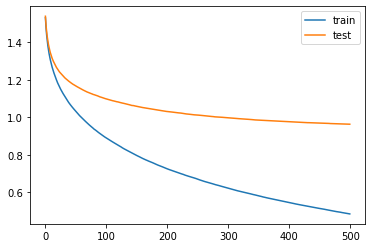

Wall time: 47min 26s


0.6343537414965986

In [28]:
%time train_and_draw_learning_curve(X=train_bow_matrix)

###  Trening modelu - wartości boolowskie

c:\users\radosław\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:49:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[21:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[21:49:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[21:49:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.

[21:50:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:50:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-mlogloss:1.31296	validation_1-mlogloss:1.35216
[21:50:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:50:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:50:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[21:50:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src

[21:51:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:51:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-mlogloss:1.21538	validation_1-mlogloss:1.27998
[21:51:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:51:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[21:51:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:51:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:51:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:51:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[26]	validation_0-mlogloss:1.15218	validation_1-mlogloss:1.23904
[21:51:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:51:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:51:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:52:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:52:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[21:52:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[35]	validation_0-mlogloss:1.10284	validation_1-mlogloss:1.20856
[21:52:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[21:52:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:52:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:52:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:53:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[21:53:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[44]	validation_0-mlogloss:1.06353	validation_1-mlogloss:1.18705
[21:53:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[21:53:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[21:53:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:53:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:54:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:54:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[53]	validation_0-mlogloss:1.02935	validation_1-mlogloss:1.16920
[21:54:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[21:54:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:54:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[21:54:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:55:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:55:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[62]	validation_0-mlogloss:0.99929	validation_1-mlogloss:1.15380
[21:55:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[21:55:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:55:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:55:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:56:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:56:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[71]	validation_0-mlogloss:0.97207	validation_1-mlogloss:1.13948
[21:56:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:56:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[21:56:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:56:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:57:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[21:57:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[80]	validation_0-mlogloss:0.94836	validation_1-mlogloss:1.12729
[21:57:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:57:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:57:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:57:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:57:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:57:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[89]	validation_0-mlogloss:0.92491	validation_1-mlogloss:1.11705
[21:57:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[21:57:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[21:57:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[21:57:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:58:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[21:58:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[98]	validation_0-mlogloss:0.90486	validation_1-mlogloss:1.10863
[21:58:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[21:58:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[21:58:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[21:58:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[21:59:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[21:59:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[107]	validation_0-mlogloss:0.88627	validation_1-mlogloss:1.09956
[21:59:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:59:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[21:59:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[21:59:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:00:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[22:00:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[116]	validation_0-mlogloss:0.86808	validation_1-mlogloss:1.09065
[22:00:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:00:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:00:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:00:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:01:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:01:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[125]	validation_0-mlogloss:0.85127	validation_1-mlogloss:1.08268
[22:01:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:01:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:01:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:01:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:02:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:02:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[134]	validation_0-mlogloss:0.83517	validation_1-mlogloss:1.07605
[22:02:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:02:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:02:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:02:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:02:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:02:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[143]	validation_0-mlogloss:0.82020	validation_1-mlogloss:1.06946
[22:02:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:02:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:02:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:02:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:03:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[22:03:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[152]	validation_0-mlogloss:0.80532	validation_1-mlogloss:1.06382
[22:03:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:03:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:03:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:03:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:04:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[22:04:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[161]	validation_0-mlogloss:0.79185	validation_1-mlogloss:1.05937
[22:04:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:04:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:04:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:04:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:05:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:05:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[170]	validation_0-mlogloss:0.77870	validation_1-mlogloss:1.05445
[22:05:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[22:05:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[22:05:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:05:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:06:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:06:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[179]	validation_0-mlogloss:0.76571	validation_1-mlogloss:1.04987
[22:06:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:06:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:06:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:06:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:07:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[22:07:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[188]	validation_0-mlogloss:0.75476	validation_1-mlogloss:1.04447
[22:07:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:07:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:07:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:07:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:07:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[22:07:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[197]	validation_0-mlogloss:0.74332	validation_1-mlogloss:1.04016
[22:07:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:07:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[22:07:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[22:08:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:08:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:08:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[206]	validation_0-mlogloss:0.73188	validation_1-mlogloss:1.03570
[22:08:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[22:08:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:08:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:08:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:09:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[22:09:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[215]	validation_0-mlogloss:0.72107	validation_1-mlogloss:1.03178
[22:09:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:09:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:09:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:09:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:10:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[22:10:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[224]	validation_0-mlogloss:0.71052	validation_1-mlogloss:1.02878
[22:10:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:10:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[22:10:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[22:10:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:11:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:11:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[233]	validation_0-mlogloss:0.69969	validation_1-mlogloss:1.02509
[22:11:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:11:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[22:11:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[22:11:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:12:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:12:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[242]	validation_0-mlogloss:0.69039	validation_1-mlogloss:1.02190
[22:12:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:12:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:12:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:12:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:12:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:12:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[251]	validation_0-mlogloss:0.68159	validation_1-mlogloss:1.01822
[22:12:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:12:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:13:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:13:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:13:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:13:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[260]	validation_0-mlogloss:0.67230	validation_1-mlogloss:1.01545
[22:13:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:13:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[22:13:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:13:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:14:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:14:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[269]	validation_0-mlogloss:0.66340	validation_1-mlogloss:1.01215
[22:14:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:14:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:14:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:14:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:15:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:15:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[278]	validation_0-mlogloss:0.65515	validation_1-mlogloss:1.00994
[22:15:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:15:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:15:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:15:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:16:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:16:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[287]	validation_0-mlogloss:0.64631	validation_1-mlogloss:1.00721
[22:16:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[22:16:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:16:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:16:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:17:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:17:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[296]	validation_0-mlogloss:0.63812	validation_1-mlogloss:1.00453
[22:17:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[22:17:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:17:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:17:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:17:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[22:17:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[305]	validation_0-mlogloss:0.63065	validation_1-mlogloss:1.00210
[22:17:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:17:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:18:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:18:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:18:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:18:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[314]	validation_0-mlogloss:0.62300	validation_1-mlogloss:1.00039
[22:18:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:18:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[22:18:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:18:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:19:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:19:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[323]	validation_0-mlogloss:0.61562	validation_1-mlogloss:0.99822
[22:19:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:19:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:19:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:19:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:20:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[22:20:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[332]	validation_0-mlogloss:0.60686	validation_1-mlogloss:0.99606
[22:20:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:20:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:20:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:20:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:21:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:21:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[341]	validation_0-mlogloss:0.60047	validation_1-mlogloss:0.99449
[22:21:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:21:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:21:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:21:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:22:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:22:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[350]	validation_0-mlogloss:0.59431	validation_1-mlogloss:0.99250
[22:22:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:22:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:22:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:22:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:22:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:22:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[359]	validation_0-mlogloss:0.58714	validation_1-mlogloss:0.99057
[22:22:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[22:23:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:23:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:23:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:23:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:23:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[368]	validation_0-mlogloss:0.58054	validation_1-mlogloss:0.98872
[22:23:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[22:23:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:23:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:23:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:24:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:24:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[377]	validation_0-mlogloss:0.57405	validation_1-mlogloss:0.98691
[22:24:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:24:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:24:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:24:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:25:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:25:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[386]	validation_0-mlogloss:0.56762	validation_1-mlogloss:0.98610
[22:25:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:25:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:25:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:25:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:26:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:26:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[395]	validation_0-mlogloss:0.56175	validation_1-mlogloss:0.98462
[22:26:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:26:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:26:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:26:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:27:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:27:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[404]	validation_0-mlogloss:0.55553	validation_1-mlogloss:0.98396
[22:27:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:27:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:27:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:27:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:28:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:28:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[413]	validation_0-mlogloss:0.54980	validation_1-mlogloss:0.98236
[22:28:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:28:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[22:28:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[22:28:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:28:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:28:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[422]	validation_0-mlogloss:0.54402	validation_1-mlogloss:0.98093
[22:28:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:28:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:28:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:29:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:29:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[22:29:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[431]	validation_0-mlogloss:0.53823	validation_1-mlogloss:0.97971
[22:29:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:29:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:29:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:29:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:30:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:30:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[440]	validation_0-mlogloss:0.53291	validation_1-mlogloss:0.97839
[22:30:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:30:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:30:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:30:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:31:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:31:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[449]	validation_0-mlogloss:0.52785	validation_1-mlogloss:0.97700
[22:31:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:31:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:31:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:31:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:32:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[22:32:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[458]	validation_0-mlogloss:0.52230	validation_1-mlogloss:0.97538
[22:32:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[22:32:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:32:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:32:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:33:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:33:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[467]	validation_0-mlogloss:0.51680	validation_1-mlogloss:0.97403
[22:33:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:33:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[22:33:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:33:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:33:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[22:33:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[476]	validation_0-mlogloss:0.51178	validation_1-mlogloss:0.97341
[22:33:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:33:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:33:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:34:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:34:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:34:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[485]	validation_0-mlogloss:0.50719	validation_1-mlogloss:0.97311
[22:34:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:34:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:34:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:34:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:35:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:35:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[494]	validation_0-mlogloss:0.50216	validation_1-mlogloss:0.97220
[22:35:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:35:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:35:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:35:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

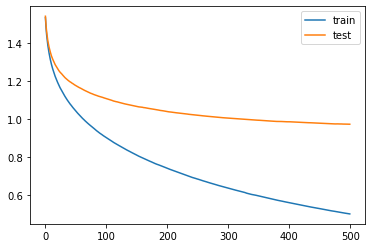

Wall time: 46min 50s


0.6335034013605442

In [29]:
%time train_and_draw_learning_curve(X=bool_matrix)

W przypadku BOW i uproszczonej jego wersji, wyniki okazały się niemal identyczne. Prawdopodobnie wynika to z faktu, że w przypadku tak krótkiej formy wypowiedzi, jak tweet, rzadko się zdarza, by jakieś słowo występowało częściej niż raz. Zatem macierz BOW nie zawierała szczególnie więcej informacji od macierzy wartości boolowskich.

### Trening modelu - TF-IDF

c:\users\radosław\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:36:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:36:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[22:36:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=6
[22:36:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[22:36:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.

[22:37:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[22:37:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[8]	validation_0-mlogloss:1.28752	validation_1-mlogloss:1.34272
[22:37:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[22:37:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:37:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[22:37:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src

[22:37:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[22:37:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-mlogloss:1.18226	validation_1-mlogloss:1.27594
[22:37:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[22:37:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[22:38:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[22:38:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[22:38:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:38:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[26]	validation_0-mlogloss:1.11393	validation_1-mlogloss:1.23435
[22:38:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[22:38:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[22:38:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:38:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[22:39:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:39:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[35]	validation_0-mlogloss:1.06117	validation_1-mlogloss:1.20622
[22:39:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[22:39:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:39:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:39:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[22:40:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:40:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[44]	validation_0-mlogloss:1.01901	validation_1-mlogloss:1.18341
[22:40:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:40:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[22:40:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[22:40:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[22:41:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:41:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[53]	validation_0-mlogloss:0.98481	validation_1-mlogloss:1.16659
[22:41:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:41:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:41:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:41:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[22:42:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:42:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[62]	validation_0-mlogloss:0.95016	validation_1-mlogloss:1.15045
[22:42:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:42:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:42:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:42:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[22:43:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[22:43:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[71]	validation_0-mlogloss:0.92137	validation_1-mlogloss:1.13778
[22:43:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:43:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:43:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[22:43:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[22:43:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:43:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[80]	validation_0-mlogloss:0.89552	validation_1-mlogloss:1.12704
[22:43:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[22:43:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[22:43:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:43:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[22:44:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:44:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[89]	validation_0-mlogloss:0.87114	validation_1-mlogloss:1.11670
[22:44:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:44:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[22:44:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:44:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[22:45:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:45:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[98]	validation_0-mlogloss:0.84737	validation_1-mlogloss:1.10803
[22:45:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:45:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:45:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:45:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/sr

[22:46:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:46:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[107]	validation_0-mlogloss:0.82676	validation_1-mlogloss:1.09964
[22:46:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:46:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:46:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:46:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:47:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:47:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[116]	validation_0-mlogloss:0.80724	validation_1-mlogloss:1.09259
[22:47:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:47:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:47:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[22:47:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:48:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:48:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[125]	validation_0-mlogloss:0.78997	validation_1-mlogloss:1.08600
[22:48:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:48:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:48:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:48:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:48:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:48:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[134]	validation_0-mlogloss:0.77174	validation_1-mlogloss:1.08054
[22:48:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[22:49:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:49:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:49:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:49:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:49:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[143]	validation_0-mlogloss:0.75534	validation_1-mlogloss:1.07471
[22:49:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:49:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:49:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:49:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:50:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[22:50:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[152]	validation_0-mlogloss:0.73925	validation_1-mlogloss:1.07020
[22:50:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:50:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:50:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:50:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:51:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[22:51:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[161]	validation_0-mlogloss:0.72547	validation_1-mlogloss:1.06447
[22:51:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:51:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[22:51:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:51:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:52:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[22:52:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[170]	validation_0-mlogloss:0.71056	validation_1-mlogloss:1.06018
[22:52:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:52:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:52:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:52:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:53:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[22:53:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[179]	validation_0-mlogloss:0.69752	validation_1-mlogloss:1.05518
[22:53:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[22:53:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:53:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:53:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:54:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[22:54:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[188]	validation_0-mlogloss:0.68526	validation_1-mlogloss:1.05167
[22:54:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:54:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[22:54:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:54:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:54:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[22:54:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[197]	validation_0-mlogloss:0.67265	validation_1-mlogloss:1.04772
[22:55:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[22:55:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=6
[22:55:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[22:55:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:55:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[22:55:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[206]	validation_0-mlogloss:0.65972	validation_1-mlogloss:1.04492
[22:55:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:55:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:55:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:55:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:56:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:56:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[215]	validation_0-mlogloss:0.64801	validation_1-mlogloss:1.04163
[22:56:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:56:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[22:56:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:56:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:57:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[22:57:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[224]	validation_0-mlogloss:0.63676	validation_1-mlogloss:1.03850
[22:57:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:57:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[22:57:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[22:57:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:58:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:58:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[233]	validation_0-mlogloss:0.62668	validation_1-mlogloss:1.03586
[22:58:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[22:58:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[22:58:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[22:58:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[22:59:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[22:59:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[242]	validation_0-mlogloss:0.61536	validation_1-mlogloss:1.03301
[22:59:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[22:59:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:59:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[22:59:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:00:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:00:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[251]	validation_0-mlogloss:0.60609	validation_1-mlogloss:1.03012
[23:00:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:00:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[23:00:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:00:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:00:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[23:00:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[260]	validation_0-mlogloss:0.59634	validation_1-mlogloss:1.02774
[23:01:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[23:01:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:01:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:01:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:01:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:01:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[269]	validation_0-mlogloss:0.58724	validation_1-mlogloss:1.02559
[23:01:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:01:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:01:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:01:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:02:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:02:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[278]	validation_0-mlogloss:0.57809	validation_1-mlogloss:1.02405
[23:02:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:02:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[23:02:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:02:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:03:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[23:03:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[287]	validation_0-mlogloss:0.56871	validation_1-mlogloss:1.02159
[23:03:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:03:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[23:03:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[23:03:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:04:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[23:04:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[296]	validation_0-mlogloss:0.55971	validation_1-mlogloss:1.01999
[23:04:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[23:04:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[23:04:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[23:04:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:05:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:05:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[305]	validation_0-mlogloss:0.55145	validation_1-mlogloss:1.01799
[23:05:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:05:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[23:05:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:05:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:06:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:06:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[314]	validation_0-mlogloss:0.54384	validation_1-mlogloss:1.01640
[23:06:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:06:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:06:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:06:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:07:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[23:07:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[323]	validation_0-mlogloss:0.53580	validation_1-mlogloss:1.01465
[23:07:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[23:07:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:07:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:07:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:07:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:07:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[332]	validation_0-mlogloss:0.52808	validation_1-mlogloss:1.01260
[23:07:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[23:08:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[23:08:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:08:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:08:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:08:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[341]	validation_0-mlogloss:0.52022	validation_1-mlogloss:1.01112
[23:08:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[23:08:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[23:08:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:08:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:09:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[23:09:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[350]	validation_0-mlogloss:0.51250	validation_1-mlogloss:1.00955
[23:09:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:09:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:09:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:09:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:10:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[23:10:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[359]	validation_0-mlogloss:0.50545	validation_1-mlogloss:1.00815
[23:10:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[23:10:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[23:10:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:10:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:11:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[23:11:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[368]	validation_0-mlogloss:0.49796	validation_1-mlogloss:1.00682
[23:11:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:11:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:11:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:11:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:12:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[23:12:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[377]	validation_0-mlogloss:0.49122	validation_1-mlogloss:1.00626
[23:12:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:12:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:12:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:12:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:13:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:13:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[386]	validation_0-mlogloss:0.48402	validation_1-mlogloss:1.00500
[23:13:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[23:13:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[23:13:12] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:13:13] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:13:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:13:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[395]	validation_0-mlogloss:0.47764	validation_1-mlogloss:1.00460
[23:14:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:14:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:14:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:14:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:14:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[23:14:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[404]	validation_0-mlogloss:0.47133	validation_1-mlogloss:1.00302
[23:14:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:14:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:14:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[23:14:55] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:15:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:15:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[413]	validation_0-mlogloss:0.46488	validation_1-mlogloss:1.00198
[23:15:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[23:15:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[23:15:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:15:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:16:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:16:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[422]	validation_0-mlogloss:0.45856	validation_1-mlogloss:1.00092
[23:16:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:16:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:16:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:16:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:17:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:17:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[431]	validation_0-mlogloss:0.45262	validation_1-mlogloss:1.00019
[23:17:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[23:17:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[23:17:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[23:17:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:18:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[23:18:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[440]	validation_0-mlogloss:0.44671	validation_1-mlogloss:0.99891
[23:18:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:18:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:18:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:18:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:19:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:19:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[449]	validation_0-mlogloss:0.44055	validation_1-mlogloss:0.99767
[23:19:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:19:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:19:10] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:19:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:19:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:19:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[458]	validation_0-mlogloss:0.43551	validation_1-mlogloss:0.99727
[23:19:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:20:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[23:20:01] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=6
[23:20:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:20:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[23:20:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[467]	validation_0-mlogloss:0.42956	validation_1-mlogloss:0.99667
[23:20:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[23:20:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:20:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[23:20:54] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:21:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[23:21:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[476]	validation_0-mlogloss:0.42419	validation_1-mlogloss:0.99587
[23:21:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[23:21:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:21:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[23:21:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:22:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=6
[23:22:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=6
[485]	validation_0-mlogloss:0.41884	validation_1-mlogloss:0.99555
[23:22:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:22:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[23:22:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[23:22:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

[23:23:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:23:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[494]	validation_0-mlogloss:0.41277	validation_1-mlogloss:0.99490
[23:23:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[23:23:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=6
[23:23:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[23:23:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/s

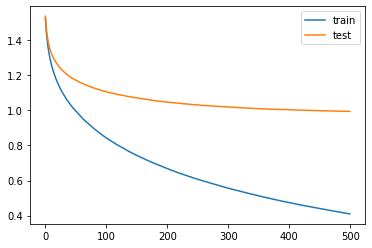

Wall time: 47min 50s


0.6050777453838678

In [30]:
%time train_and_draw_learning_curve(X=tf_idf_matrix)

###### Co ciekawe, TF-IDF osiągnęło najniższą skuteczność ze wszystkich. We wszystkich przypadkach krzywe uczenia zdecydowanie odbiegają od siebie, co świadczy z dużą pewnością o przeuczeniu, tj. zbytnim dopasowaniu do danych uczących - model osiąga zdecydowanie lepsze rezultaty na danych uczących, aniżeli testowych. W przypadku TF-IDF przeuczenie jest najbardziej widoczne, co może wynikać z tego, iż technika pozwala zawrzeć więcej informacji od pozostałych. Co istotne, w dalszych eksprerymentach różnice między BOW i TF-IDF pogłębiały się na korzyść pierwszego z nich.